<a href="https://colab.research.google.com/github/prakash-bisht/NN_Architecture_From_Scratch/blob/main/Qwen3_Moe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

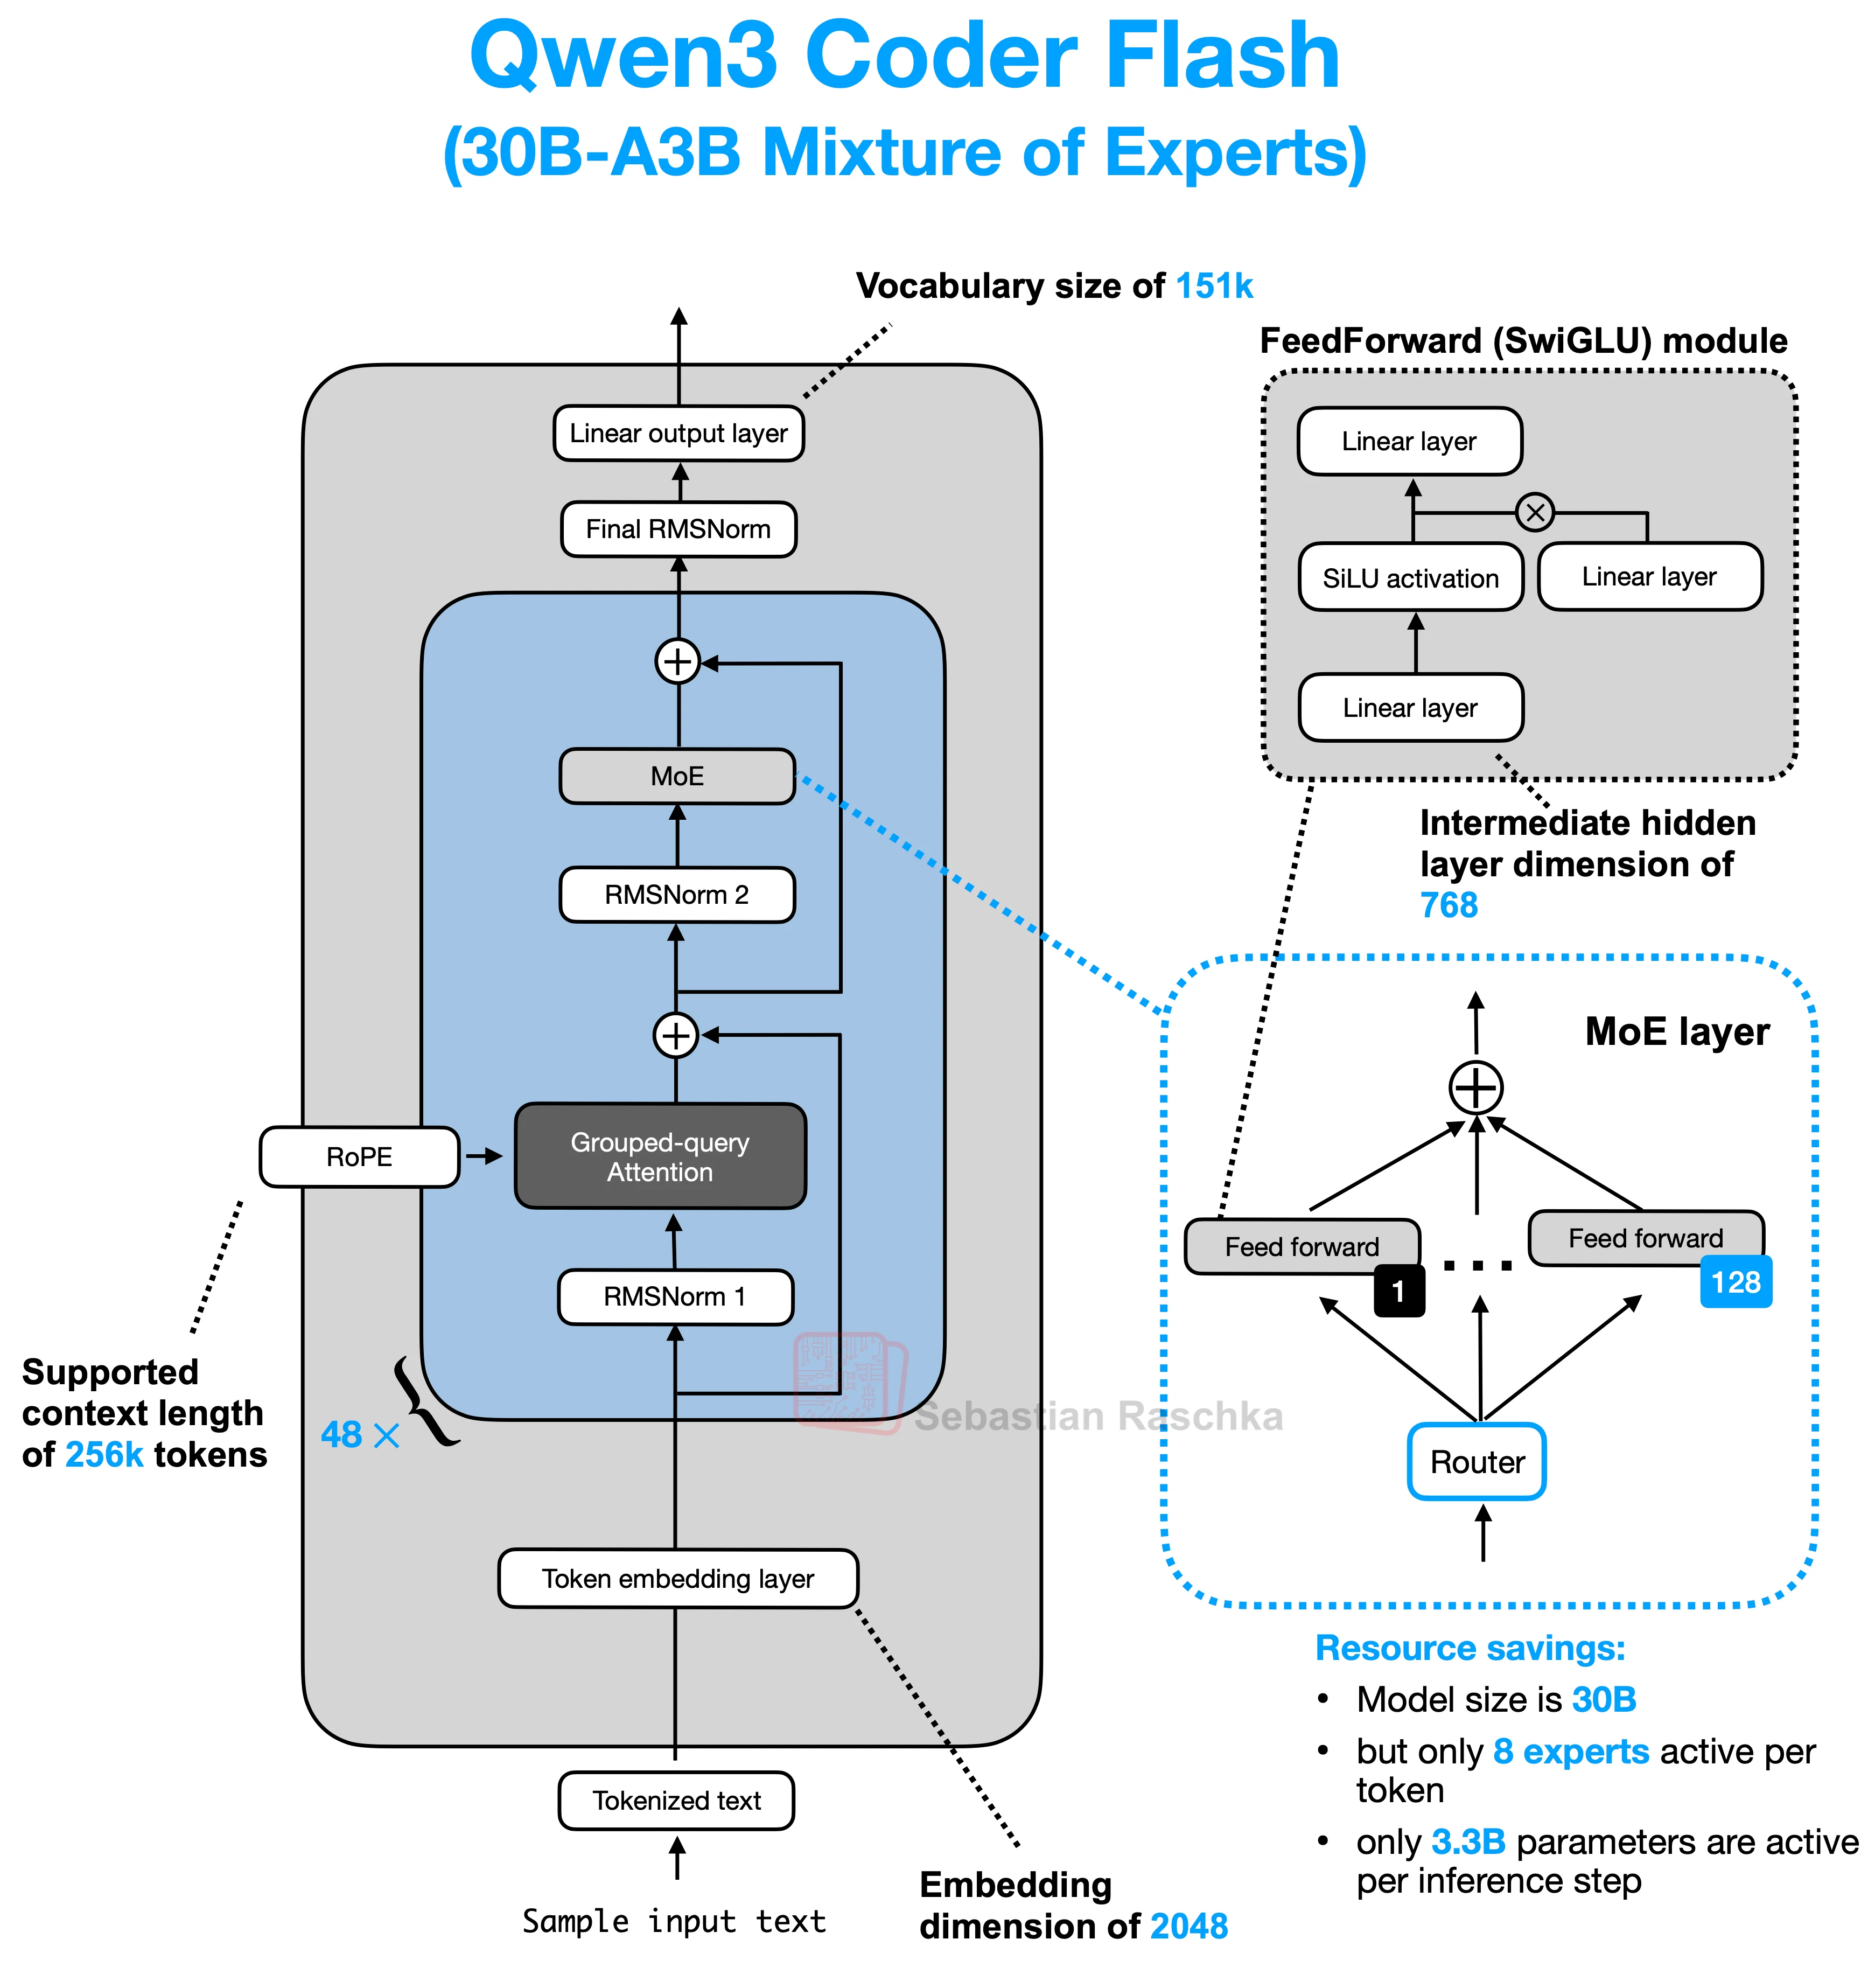

In [3]:
import torch
import torch.nn as nn

class MoEFeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.num_experts_per_tok = cfg["num_experts_per_tok"]
        self.num_experts = cfg["num_experts"]
        self.gate = nn.Linear(cfg["emb_dim"], cfg["num_experts"], bias=False, dtype=cfg["dtype"])

        meta_device = torch.device("meta")
        self.fc1 = nn.ModuleList([
            nn.Linear(
                cfg["emb_dim"], cfg["moe_intermediate_size"],
                bias=False, dtype=cfg["dtype"], device=meta_device)
            for _ in range(cfg["num_experts"])]
        )
        self.fc2 = nn.ModuleList([
            nn.Linear(
                cfg["emb_dim"], cfg["moe_intermediate_size"],
                bias=False, dtype=cfg["dtype"], device=meta_device
                )
            for _ in range(cfg["num_experts"])]
        )
        self.fc3 = nn.ModuleList([
            nn.Linear(
                cfg["moe_intermediate_size"], cfg["emb_dim"],
                bias=False, dtype=cfg["dtype"], device=meta_device
                )
            for _ in range(cfg["num_experts"])]
        )

    def forward(self, x):
        b, seq_len, embed_dim = x.shape
        scores = self.gate(x)  # (b, seq_len, num_experts)
        topk_scores, topk_indices = torch.topk(scores, self.num_experts_per_tok, dim=-1)
        topk_probs = torch.softmax(topk_scores, dim=-1)

        expert_outputs = []
        for e in range(self.num_experts):
            hidden = torch.nn.functional.silu(self.fc1[e](x)) * self.fc2[e](x)
            out = self.fc3[e](hidden)
            expert_outputs.append(out.unsqueeze(-2))
        expert_outputs = torch.cat(expert_outputs, dim=-2)  # (b, t, num_experts, emb_dim)

        gating_probs = torch.zeros_like(scores)

        for i in range(self.num_experts_per_tok):
            indices = topk_indices[..., i:i+1]
            prob = topk_probs[..., i:i+1]
            gating_probs.scatter_(dim=-1, index=indices, src=prob)
        gating_probs = gating_probs.unsqueeze(-1)  # (b, t, num_experts, 1)

        # Weighted sum over experts
        y = (gating_probs * expert_outputs).sum(dim=-2)
        return y


In [4]:
class RMSNorm(nn.Module):
    def __init__(self, emb_dim, eps=1e-6, bias=False, qwen3_compatible=True):
        super().__init__()
        self.eps = eps
        self.qwen3_compatible = qwen3_compatible
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim)) if bias else None

    def forward(self, x):
        input_dtype = x.dtype

        if self.qwen3_compatible:
            x = x.to(torch.float32)

        variance = x.pow(2).mean(dim=-1, keepdim=True)
        norm_x = x * torch.rsqrt(variance + self.eps)
        norm_x = norm_x * self.scale

        if self.shift is not None:
            norm_x = norm_x + self.shift

        return norm_x.to(input_dtype)

In [7]:
def compute_rope_params(head_dim, theta_base=10_000, context_length=4096, dtype=torch.float32):
    assert head_dim % 2 == 0, "Embedding dimension must be even"

    inv_freq = 1.0 / (theta_base ** (torch.arange(0, head_dim, 2, dtype=dtype)[: (head_dim // 2)].float() / head_dim))
    positions = torch.arange(context_length, dtype=dtype)
    angles = positions[:, None] * inv_freq[None, :]  # Shape: (context_length, head_dim // 2)
    angles = torch.cat([angles, angles], dim=1)  # Shape: (context_length, head_dim)
    cos = torch.cos(angles)
    sin = torch.sin(angles)

    return cos, sin


def apply_rope(x, cos, sin):
    # x: (batch_size, num_heads, seq_len, head_dim)
    batch_size, num_heads, seq_len, head_dim = x.shape
    assert head_dim % 2 == 0, "Head dimension must be even"

    x1 = x[..., : head_dim // 2]  # First half
    x2 = x[..., head_dim // 2 :]  # Second half

    cos = cos[:seq_len, :].unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
    sin = sin[:seq_len, :].unsqueeze(0).unsqueeze(0)

    rotated = torch.cat((-x2, x1), dim=-1)
    x_rotated = (x * cos) + (rotated * sin)

    return x_rotated.to(dtype=x.dtype)

In [8]:
class GroupedQueryAttention(nn.Module):
    def __init__(
        self, d_in, num_heads, num_kv_groups, head_dim=None, qk_norm=False, dtype=None
    ):
        super().__init__()
        assert num_heads % num_kv_groups == 0, "num_heads must be divisible by num_kv_groups"

        self.num_heads = num_heads
        self.num_kv_groups = num_kv_groups
        self.group_size = num_heads // num_kv_groups

        if head_dim is None:
            assert d_in % num_heads == 0, "`d_in` must be divisible by `num_heads` if `head_dim` is not set"
            head_dim = d_in // num_heads

        self.head_dim = head_dim
        self.d_out = num_heads * head_dim

        self.W_query = nn.Linear(d_in, self.d_out, bias=False, dtype=dtype)
        self.W_key = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)
        self.W_value = nn.Linear(d_in, num_kv_groups * head_dim, bias=False, dtype=dtype)

        self.out_proj = nn.Linear(self.d_out, d_in, bias=False, dtype=dtype)

        if qk_norm:
            self.q_norm = RMSNorm(head_dim, eps=1e-6)
            self.k_norm = RMSNorm(head_dim, eps=1e-6)
        else:
            self.q_norm = self.k_norm = None

    def forward(self, x, mask, cos, sin):
        b, num_tokens, _ = x.shape
        queries = self.W_query(x)  # (b, num_tokens, num_heads * head_dim)
        keys = self.W_key(x)       # (b, num_tokens, num_kv_groups * head_dim)
        values = self.W_value(x)   # (b, num_tokens, num_kv_groups * head_dim)

        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim).transpose(1, 2)
        keys = keys.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)
        values = values.view(b, num_tokens, self.num_kv_groups, self.head_dim).transpose(1, 2)

        # Optional normalization
        if self.q_norm:
            queries = self.q_norm(queries)
        if self.k_norm:
            keys = self.k_norm(keys)

        queries = apply_rope(queries, cos, sin)
        keys = apply_rope(keys, cos, sin)

        keys = keys.repeat_interleave(self.group_size, dim=1)
        values = values.repeat_interleave(self.group_size, dim=1)

        attn_scores = queries @ keys.transpose(2, 3)
        attn_scores = attn_scores.masked_fill(mask, -torch.inf)
        attn_weights = torch.softmax(attn_scores / self.head_dim**0.5, dim=-1)

        context = (attn_weights @ values).transpose(1, 2).reshape(b, num_tokens, self.d_out)
        return self.out_proj(context)

In [10]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = GroupedQueryAttention(
            d_in=cfg["emb_dim"],
            num_heads=cfg["n_heads"],
            head_dim=cfg["head_dim"],
            num_kv_groups=cfg["n_kv_groups"],
            qk_norm=cfg["qk_norm"],
            dtype=cfg["dtype"]
        )

        self.ff = MoEFeedForward(cfg)
        self.norm1 = RMSNorm(cfg["emb_dim"], eps=1e-6)
        self.norm2 = RMSNorm(cfg["emb_dim"], eps=1e-6)

    def forward(self, x, mask, cos, sin):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x, mask, cos, sin)  # Shape [batch_size, num_tokens, emb_size]
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = x + shortcut

        return x

In [11]:
class Qwen3Model(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"], dtype=cfg["dtype"])

        self.trf_blocks = nn.ModuleList(  # ModuleList since Sequential can only accept one input, and we need `x, mask, cos, sin`
            [TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        )

        self.final_norm = RMSNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False, dtype=cfg["dtype"])

        # Reusuable utilities
        if cfg["head_dim"] is None:
            head_dim = cfg["emb_dim"] // cfg["n_heads"]
        else:
            head_dim = cfg["head_dim"]
        cos, sin = compute_rope_params(
            head_dim=head_dim,
            theta_base=cfg["rope_base"],
            context_length=cfg["context_length"]
        )
        self.register_buffer("cos", cos, persistent=False)
        self.register_buffer("sin", sin, persistent=False)
        self.cfg = cfg


    def forward(self, in_idx):
        # Forward pass
        tok_embeds = self.tok_emb(in_idx)
        x = tok_embeds

        num_tokens = x.shape[1]
        mask = torch.triu(torch.ones(num_tokens, num_tokens, device=x.device, dtype=torch.bool), diagonal=1)

        for block in self.trf_blocks:
            x = block(x, mask, self.cos, self.sin)
        x = self.final_norm(x)
        logits = self.out_head(x.to(self.cfg["dtype"]))
        return logits

In [12]:
QWEN3_CONFIG = {
    "vocab_size": 151_936,
    "context_length": 262_144,
    "emb_dim": 2048,
    "n_heads": 32,
    "n_layers": 48,
    "head_dim": 128,
    "qk_norm": True,
    "n_kv_groups": 4,
    "rope_base": 10_000_000.0,
    "dtype": torch.bfloat16,
    "num_experts": 128,
    "num_experts_per_tok": 8,
        "moe_intermediate_size": 768,
}

In [13]:
model = Qwen3Model(QWEN3_CONFIG)
model

Qwen3Model(
  (tok_emb): Embedding(151936, 2048)
  (trf_blocks): ModuleList(
    (0-47): 48 x TransformerBlock(
      (att): GroupedQueryAttention(
        (W_query): Linear(in_features=2048, out_features=4096, bias=False)
        (W_key): Linear(in_features=2048, out_features=512, bias=False)
        (W_value): Linear(in_features=2048, out_features=512, bias=False)
        (out_proj): Linear(in_features=4096, out_features=2048, bias=False)
        (q_norm): RMSNorm()
        (k_norm): RMSNorm()
      )
      (ff): MoEFeedForward(
        (gate): Linear(in_features=2048, out_features=128, bias=False)
        (fc1): ModuleList(
          (0-127): 128 x Linear(in_features=2048, out_features=768, bias=False)
        )
        (fc2): ModuleList(
          (0-127): 128 x Linear(in_features=2048, out_features=768, bias=False)
        )
        (fc3): ModuleList(
          (0-127): 128 x Linear(in_features=768, out_features=2048, bias=False)
        )
      )
      (norm1): RMSNorm()
      (n